In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Using GPU:", gpus)
    except RuntimeError as e:
        print("Error:", e)
else:
    print("No GPU detected. Running on CPU.")

Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


##  Import the Required Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


## Load and Preprocess the Dataset

In [3]:
base_dir = "/kaggle/input/leapgestrecog/leapGestRecog"

data = []

for sub_dir in os.listdir(base_dir):
    sub_dir_path = os.path.join(base_dir, sub_dir)
    if os.path.isdir(sub_dir_path):  
        for label in os.listdir(sub_dir_path):
            label_path = os.path.join(sub_dir_path, label)
            if os.path.isdir(label_path):  
                for image_file in os.listdir(label_path):
                    if image_file.endswith(('.png', '.jpg', '.jpeg')): 
                        image_path = os.path.join(label_path, image_file)
                        data.append({'image_path': image_path, 'label': label})

df = pd.DataFrame(data)


In [4]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42, shuffle=True)


In [5]:

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 14000
Validation samples: 3000
Testing samples: 3000


In [6]:
def process_images(file_paths, target_size=(224, 224)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size) 
        img_array = img_to_array(img) / 255.0  
        images.append(img_array)
    return np.array(images)

X_train = process_images(train_df['image_path'])
X_val = process_images(val_df['image_path'])
X_test = process_images(test_df['image_path'])


In [7]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np

label_encoder = LabelEncoder()


Y_train_int = label_encoder.fit_transform(train_df['label'])
Y_train = to_categorical(Y_train_int,10)

Y_val_int = label_encoder.transform(val_df['label'])
Y_val = to_categorical(Y_val_int,10)

Y_test_int = label_encoder.transform(test_df['label'])
Y_test = to_categorical(Y_test_int,10)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)


## Define the DenseNet Model

In [8]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dropout(0.5)(x) 
x = Dense(128, activation='relu')(x) 
x = Dropout(0.5)(x)  
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x) 

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Create the model



In [9]:
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    validation_data=(X_val, Y_val),
    epochs=20,
    verbose=1
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734570463.690212      68 service.cc:145] XLA service 0x7aef90002da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734570463.691980      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734570463.691990      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/438 ━━━━━━━━━━━━━━━━━━━━ 4:12:05 35s/step - accuracy: 0.0312 - loss: 4.1556

I0000 00:00:1734570482.811648      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


438/438 ━━━━━━━━━━━━━━━━━━━━ 217s 418ms/step - accuracy: 0.1521 - loss: 2.6972 - val_accuracy: 0.7723 - val_loss: 1.5020
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 151s 340ms/step - accuracy: 0.4229 - loss: 1.6587 - val_accuracy: 0.9063 - val_loss: 0.6888
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 152s 341ms/step - accuracy: 0.5834 - loss: 1.1990 - val_accuracy: 0.9483 - val_loss: 0.3822
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 151s 340ms/step - accuracy: 0.6772 - loss: 0.9273 - val_accuracy: 0.9623 - val_loss: 0.2589
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 152s 341ms/step - accuracy: 0.7272 - loss: 0.7788 - val_accuracy: 0.9740 - val_loss: 0.1984
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 152s 341ms/step - accuracy: 0.7676 - loss: 0.6638 - val_accuracy: 0.9773 - val_loss: 0.1575
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 152s 342ms/step - accuracy: 0.7918 - loss: 0.6026 - val_accuracy: 0.9803 - val_loss: 0.1310
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 151s 339ms/step - accuracy: 0.8098 - loss: 0.55

##  Evaluate the Model 

Test Accuracy: 99.40%
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step


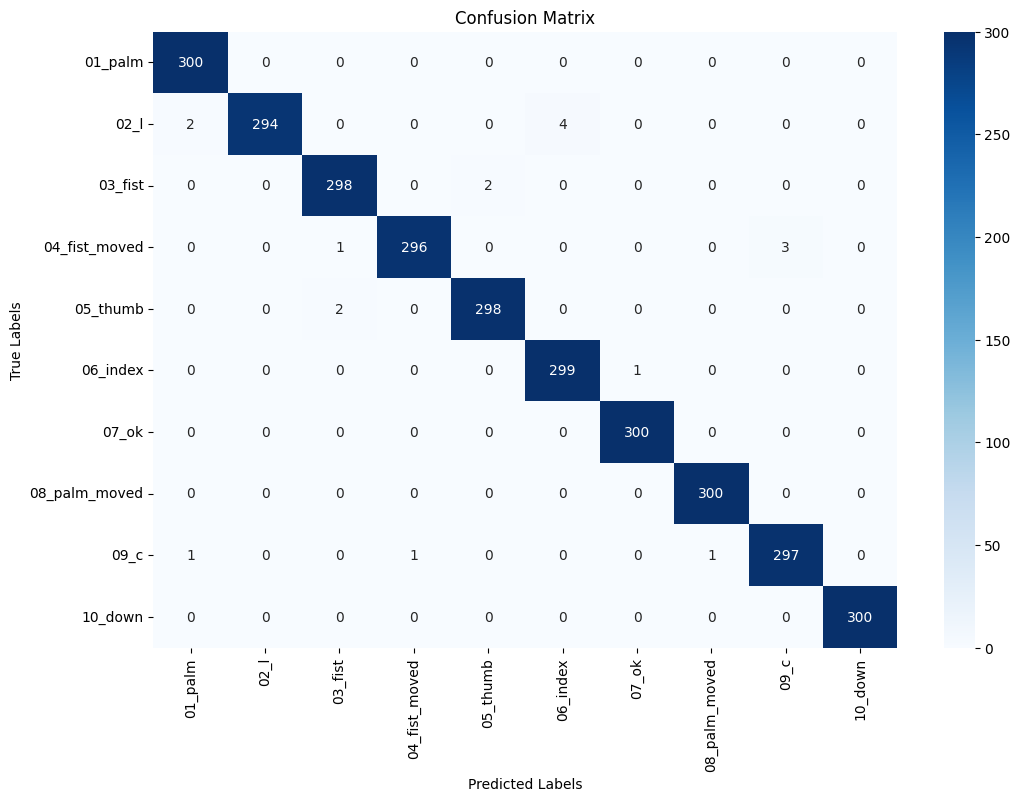

               precision    recall  f1-score   support

      01_palm       0.99      1.00      1.00       300
         02_l       1.00      0.98      0.99       300
      03_fist       0.99      0.99      0.99       300
04_fist_moved       1.00      0.99      0.99       300
     05_thumb       0.99      0.99      0.99       300
     06_index       0.99      1.00      0.99       300
        07_ok       1.00      1.00      1.00       300
08_palm_moved       1.00      1.00      1.00       300
         09_c       0.99      0.99      0.99       300
      10_down       1.00      1.00      1.00       300

     accuracy                           0.99      3000
    macro avg       0.99      0.99      0.99      3000
 weighted avg       0.99      0.99      0.99      3000

ROC-AUC Score: 1.00


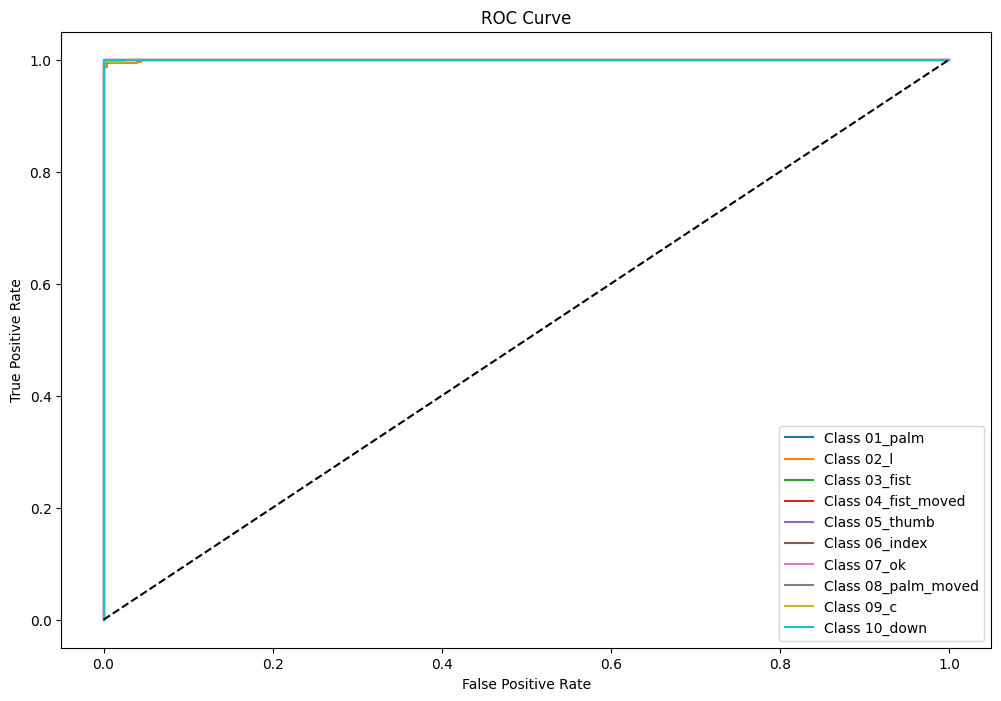

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import seaborn as sns
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true_classes, Y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(Y_true_classes, Y_pred_classes, target_names=label_encoder.classes_))

roc_auc = roc_auc_score(Y_test, Y_pred, multi_class='ovr')
print(f"ROC-AUC Score: {roc_auc:.2f}")

fpr = {}
tpr = {}
thresholds = {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], thresholds[i] = roc_curve(Y_test[:, i], Y_pred[:, i])

plt.figure(figsize=(12, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

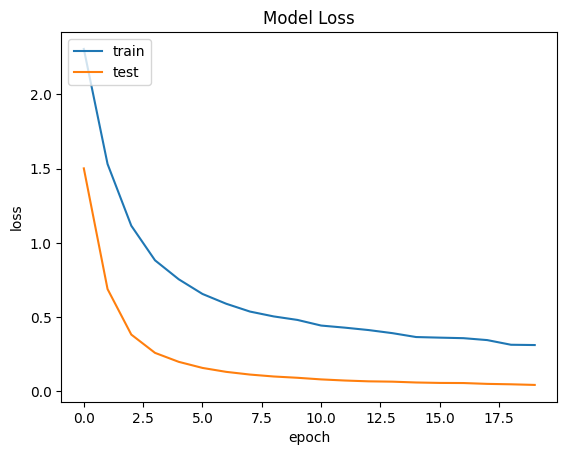

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

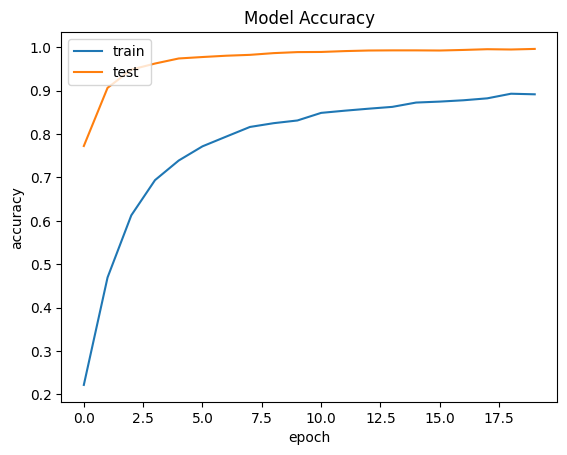

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()